In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import metapack as mp
from pathlib import Path
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.regression.linear_model import OLS
import seaborn as sns
import json

%run ./lib.py

In [31]:
import metapack as mp
pkg = mp.open_package('http://library.metatab.org/federalreserve.gov-consumer_finances-2016-inherit-1.1.1.csv')
pkg

# Survey of Consumer Finances, Inheritance Extract
`federalreserve.gov-consumer_finances-2016-inherit-1.1.1` Last Update: 2020-10-21T04:21:11

_An Extract from the survey of consumer finances for studying networth and ineritance_


## Documentation Links

* [Documentation Page](http://library.metatab.org/federalreserve.gov-consumer_finances-2016-inherit-1.1.1/index.html) 

 
## Images

[![doc_img](http://library.metatab.org/federalreserve.gov-consumer_finances-2016-inherit-1.1.1/docs/networth_race_inc.png "networth_race_inc")](http://library.metatab.org/federalreserve.gov-consumer_finances-2016-inherit-1.1.1/docs/networth_race_inc.png)

Net Worth by Income Percentile and Race
## Contacts

* **Wrangler** [Eric Busboom](mailto:eric@civicknowledge.com), [Civic Knowledge](http://civicknowledge.com)

## Resources

* ** [inherit_scf_16](http://library.metatab.org/federalreserve.gov-consumer_finances-2016-inherit-1.1.1/data/inherit_scf_16.csv)**. Extract of the 2016 SCF for inheritance and networth

## References
<ul><li> <strong><a href="https://www.federalreserve.gov/econres/files/scf2016s.zip#p16i6.dta">scf_public_16</a></strong>. Survey of consumer finances, full public dataset, 2016</li><li> <strong><a href="https://www.federalreserve.gov/econres/files/scfp2016s.zip#rscfp2016.dta">scf_extract_16</a></strong>. Survey of consumer finances, public extract, 2016</li><li> <strong><a href="https://www.federalreserve.gov/econres/files/scf2016rw1s.zip#p16_rw1.dta">scf_weights_16</a></strong>. Survey of consumer finances, replicate weights, 2016</li><ul>

In [32]:
# Create Dataframes
df = pkg.resource('inherit_scf_16').dataframe()

In [3]:
d = '/Users/eric/proj/data-projects/insights/survey_consumer_finances/federalreserve.gov-consumer_finances-2016-inherit/data/'
df = pd.read_csv(d+'inherit_scf_16.csv')

df.head()

with open('categoricals.json') as f:
    categoricals = json.load(f)
    
for c in categoricals:
    df[c] = df[c].astype('category')
    
df.head()

,case_id,record_id,implicate_id,age_1,age_2,hisp,race,addtional_race,unusual_income,ed_1,...,lt_planner,nincpctle,ninc,nwpctle,n_gift,n_inherit,n_trust,n_transfer,any_transfer,any_inherit
0,1,11,1,71,0,5,white,5,3,assoc_vocational,...,1,0,0,60,0,0,0,0,0,0
1,1,12,2,71,0,5,white,5,3,assoc_vocational,...,1,0,0,60,0,0,0,0,0,0
2,1,13,3,71,0,5,white,5,3,assoc_vocational,...,1,0,0,60,0,0,0,0,0,0
3,1,14,4,71,0,5,white,5,3,assoc_vocational,...,1,0,0,60,0,0,0,0,0,0
4,1,15,5,71,0,5,white,5,3,assoc_vocational,...,1,0,0,60,0,0,0,0,0,0


In [4]:
# Get the extract and pull out a few more variables
#scfe = pkg.reference('scf_extract').dataframe().rename(columns={'Y1': 'record_id'})
#scfe.columns = [c.lower() for c in scfe.columns]
#df = df.merge(scfe, on='record_id', suffixes=('','_other') )


In [5]:
dfs = make_sample(df, N=200_000, extra_cols=[
    'occ','occ_1', 'nincpctlecat','nwpctlecat', 'racecl','debt', 'spend_exceeds', 'saved', 'lt_planner', 'homeeq', 'debt2inc',
    'fin_risk', 'fin_know','borrow_vacation', 'spend_exceeds_excl_house'])

dfs['hhsize'] = df.married.apply( lambda v: 1 if v ==2 else 2)
dfs['networthpc'] = dfs.networth / dfs.hhsize
dfs['assetpc'] = dfs.asset / dfs.hhsize

# Create quantiles for gi_sum
o, gi_sum_bins = pd.qcut(dfs[dfs.gi_sum > 0].gi_sum, 10 , retbins = True)
gi_sum_bins[0] = 0 # So zero gets included in a bin
dfs['gi_sum_decile']  = pd.cut(dfs.gi_sum, gi_sum_bins, labels=False).fillna(0)

dfs.head()

,case_id,record_id,race,age_1,agecl,norminc,networth,asset,gi_sum,occat1,...,debt2inc,fin_risk,fin_know,borrow_vacation,spend_exceeds_excl_house,income_decile,gi_sum_decile,hhsize,networthpc,assetpc
2456,494,4942,white,62,55-64,11139.000574,71440.0,71440.0,9000,3,...,0.000000,-1,9,5,0,0,1.0,1,71440.0,71440.0
15988,3205,32054,hisp,58,55-64,25315.910396,-5890.0,14110.0,0,4,...,0.790017,3,6,5,0,1,0.0,1,-5890.0,14110.0
27391,5490,54902,white,61,55-64,283538.196439,1551000.0,1551000.0,0,1,...,0.000000,2,8,5,0,9,0.0,2,775500.0,775500.0
20418,4093,40934,white,64,55-64,72909.821941,221680.0,303900.0,0,1,...,1.127694,-1,6,5,0,6,0.0,2,110840.0,151950.0
22472,4505,45053,white,57,55-64,125566.915566,1165600.0,1171600.0,92000,2,...,0.047783,10,10,5,0,8,6.0,2,582800.0,585800.0


family structure: 
* 1=not married/LWP + children, 
* 2=not married/LWP + no children + head under 55, 
* 3=not married/LWP + no children + head 55 or older, 
* 4=married/LWP + children
* 5=married/LWP + no children;

In [6]:
t=dfs.groupby(['occ_1','race']).norminc.count().to_frame().reset_index()
pd.crosstab(t.occ_1 ,t.race, t.norminc, aggfunc=np.sum, margins=True, normalize='index')

race,black,hisp,other,white
occ_1,,,,
0,0.170140,0.080430,0.041939,0.707492
1,0.126022,0.068806,0.069016,0.736156
2,0.196521,0.120248,0.048848,0.634383
3,0.223993,0.191686,0.035338,0.548983
4,0.086788,0.223267,0.028221,0.661724
5,0.203058,0.165248,0.038186,0.593508
6,0.059446,0.231738,0.021662,0.687154
All,0.158945,0.112715,0.048190,0.680150


In [7]:
dfs[dfs.nincpctlecat <=10].groupby('occ_1').norminc.median()

occ_1
0    35442.274555
1    84757.668007
2    53669.730040
3    40505.456634
4    58732.912119
5    51644.457209
6    48723.001149
Name: norminc, dtype: float64

In [8]:
dfs[dfs.nincpctlecat <=10].groupby(['occ','agecl']).norminc.median().unstack().T.round(0)

occ,1,2,3,4,5,6,7
agecl,,,,,,,
35-44,88099.0,60758.0,39999.0,46581.0,45569.0,35442.0,24303.0
45-54,96200.0,60758.0,41518.0,45569.0,45569.0,42531.0,22278.0
55-64,94175.0,60758.0,35442.0,60758.0,51644.0,55695.0,25215.0
65-74,90125.0,68859.0,35442.0,64100.0,42531.0,63796.0,39493.0
<35,62783.0,39493.0,33417.0,36455.0,30379.0,28354.0,18227.0
>=75,76403.0,45569.0,40961.0,45569.0,42531.0,32404.0,36455.0


In [9]:
dfs[dfs.nincpctlecat <=10].groupby(['famstruct','nincpctlecat']).networth.median().unstack().T

famstruct,1,2,3,4,5
nincpctlecat,,,,,
1,4965.0,300.0,8040.0,4310.0,12130.0
2,4890.0,2880.0,55900.0,9330.0,38600.0
3,11351.0,8180.0,127650.0,14100.0,79800.0
4,20800.0,12170.0,158620.0,19005.0,74100.0
5,37310.0,42001.0,270030.0,38780.0,121010.0
6,79080.0,55800.0,341900.0,68540.0,128970.0
7,112270.0,84080.0,344700.0,91780.0,224600.0
8,160600.0,165000.0,487000.0,137600.0,273790.0
9,233100.0,331000.0,1109500.0,304900.0,594000.0


In [10]:
t.loc[:, t.dtypes ==  pd.core.arrays.integer.Int64Dtype].columns

Index([], dtype='object')

In [11]:
t = dfs.dropna().copy()

t = t[t.nwpctlecat <=10 ]

for c in dfs.loc[:, dfs.dtypes == np.float64].columns:
    t[c] = t[c].astype(float)

for c in  t.loc[:, t.dtypes ==  pd.core.arrays.integer.Int64Dtype].columns:
    try:
        t[c] = t[c].astype(int)
    except:
        pass

# Why are these not caught by the prior conversions?
#for c in ['agecl', 'housecl', 'famstruct', 'indcat', 'edcl', 'occ', 'nwpctlecat', 'racecl']:
#    t[c] = t[c].astype(int)
 
t['debt_ihs'] = np.arcsinh(t.debt)
t['asset_ihs'] = np.arcsinh(t.asset)
t['assetpc_ihs'] = np.arcsinh(t.assetpc)
t['networth_ihs'] = np.arcsinh(t.networth)
t['networthpc_ihs'] = np.arcsinh(t.networthpc)
t['norminc_ihs'] = np.arcsinh(t.norminc)
t['gi_sum_ihs'] = np.arcsinh(t.gi_sum.astype(float))

t['nwrank'] = t.networth.rank().astype(int)
t['nincrank'] = t.norminc.rank().astype(int)
t['girank'] = t.gi_sum.rank()

regr = t # [t.networth > 0] # t[(t.agecl==3) & (t.housecl==1) & (t.famstruct==4)]

regr.to_csv('regression_set.csv')

m = ols('asset_ihs ~ norminc_ihs + gi_sum_ihs + C(racecl) + C(agecl) + C(housecl) + C(famstruct) + C(edcl) + C(occ) ',
        data=regr).fit()

m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              asset_ihs   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                 1.525e+04
Date:                Tue, 20 Oct 2020   Prob (F-statistic):               0.00
Time:                        21:28:33   Log-Likelihood:            -3.4269e+05
No. Observations:              189896   AIC:                         6.854e+05
Df Residuals:                  189873   BIC:                         6.857e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   4.7516      0.062     76.074      0.000       4.629       4.874
C(racecl)[T.2]             -0.2729      0.008    -36.151      0.000      -0.288      -0.258
C(agecl)[T.45-54]           0.1707      0.011     15.016      0.000       0.148       0.193
C(agecl)[T.55-64]           0.3280      0.013     25.330      0.000       0.303       0.353
C(agecl)[T.65-74]           0.6533      0.015     42.901      0.000       0.623       0.683
C(agecl)[T.<35]            -0.0960      0.011     -8.456      0.000      -0.118      -0.074
C(agecl)[T.>=75]            0.9344      0.017     55.304      0.000       0.901       0.968
C(housecl)[T.2]            -2.5458      0.008   -309.141      0.000      -2.562      -2.530
C(famstruct)[T.2]           0.1301      0.014      9.635      0.000       0.104       0.157
C(famstruct)[T.3]          -0.0469      0.014     -3.257      0.001      -0.075      -0.019
C(famstruct)[T.4]           0.2580      0.012     21.245      0.000       0.234       0.282
C(famstruct)[T.5]           0.1362      0.013     10.797      0.000       0.111       0.161
C(edcl)[T.HS/GED]          -0.4923      0.010    -49.888      0.000      -0.512      -0.473
C(edcl)[T.No HS]           -0.9374      0.013    -72.901      0.000      -0.963      -0.912
C(edcl)[T.Some College]    -0.3056      0.009    -32.882      0.000      -0.324      -0.287
C(occ)[T.2]                -0.1984      0.011    -18.485      0.000      -0.219      -0.177
C(occ)[T.3]                -0.1919      0.013    -14.462      0.000      -0.218      -0.166
C(occ)[T.4]                -0.2920      0.016    -18.272      0.000      -0.323      -0.261
C(occ)[T.5]                -0.3252      0.018    -18.332      0.000      -0.360      -0.290
C(occ)[T.6]                 0.2455      0.043      5.761      0.000       0.162       0.329
C(occ)[T.7]                -0.6284      0.012    -54.349      0.000      -0.651      -0.606
norminc_ihs                 0.7369      0.005    147.109      0.000       0.727       0.747
gi_sum_ihs                  0.0342      0.001     43.606      0.000       0.033       0.036
==============================================================================
Omnibus:                    96092.083   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1432074.285
Skew:                          -2.081   Prob(JB):                         0.00
Kurtosis:                      15.793   Cond. No.                         223.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
dfs[(dfs.nincpctlecat<=9)&(dfs.spend_exceeds==3)].groupby(['occ','race']).norminc.mean().unstack()

race,black,hisp,other,white
occ,,,,
1,79302.189195,82578.056950,88902.126243,90404.007667
2,61606.305362,61951.633314,54186.565244,74144.578224
3,46422.795260,40915.907132,68676.766226,54413.298266
4,47380.213692,47504.806203,44467.519504,63029.441446
5,55253.931856,51993.069745,48351.022884,57790.335436
6,NaN,26328.546812,151895.462378,78457.555278
7,36498.328671,32672.865902,61150.082293,53275.539236


In [13]:
dfs[dfs.nincpctlecat<=10].groupby(['lt_planner','nincpctlecat']).networth.median().unstack().T

lt_planner,0,1
nincpctlecat,,
1,2760.0,6110.0
2,6405.0,26501.0
3,18280.0,36200.0
4,19200.0,50480.0
5,43001.0,114600.0
6,74100.0,107500.0
7,62360.0,199000.0
8,149700.0,203330.0
9,260300.0,456280.0


In [14]:
'asset_ihs ~ norminc_ihs + gi_sum_ihs + C(racecl) + C(agecl) + C(housecl) + C(famstruct) + C(edcl) + C(occ) '

dep_col = 'asset_ihs'
ob_cols = ['norminc_ihs', 'gi_sum_ihs', 'racecl']

t = regr.copy()
#t['racecl'] = (t.racecl-1).astype('uint8')

for c in 'agecl housecl famstruct edcl occ borrow_vacation spend_exceeds_excl_house fin_risk fin_know'.split():
    t[c] = t[c].astype('category')
    ob_cols.append(c)
    
y = t[dep_col]
X = pd.get_dummies(t[ob_cols])
X_ = sm.add_constant(X)
print(ob_cols)
display(X_.head())
m = OLS(y, X_).fit()
m.summary()

['norminc_ihs', 'gi_sum_ihs', 'racecl', 'agecl', 'housecl', 'famstruct', 'edcl', 'occ', 'borrow_vacation', 'spend_exceeds_excl_house', 'fin_risk', 'fin_know']


,const,norminc_ihs,gi_sum_ihs,racecl_1,racecl_2,agecl_35-44,agecl_45-54,agecl_55-64,agecl_65-74,agecl_<35,...,fin_know_1,fin_know_2,fin_know_3,fin_know_4,fin_know_5,fin_know_6,fin_know_7,fin_know_8,fin_know_9,fin_know_10
2456,1.0,10.011355,9.798127,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
15988,1.0,10.832336,0.000000,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
27391,1.0,13.248249,0.000000,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
20418,1.0,11.890126,0.000000,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
22472,1.0,12.433741,12.122691,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              asset_ihs   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     7563.
Date:                Tue, 20 Oct 2020   Prob (F-statistic):               0.00
Time:                        21:28:34   Log-Likelihood:            -3.4048e+05
No. Observations:              189896   AIC:                         6.811e+05
Df Residuals:                  189849   BIC:                         6.815e+05
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.9915      0.016     62.064      0.000       0.960       1.023
norminc_ihs                    0.7010      0.005    140.024      0.000       0.691       0.711
gi_sum_ihs                     0.0316      0.001     40.606      0.000       0.030       0.033
racecl_1                       0.6330      0.009     70.125      0.000       0.615       0.651
racecl_2                       0.3585      0.009     41.591      0.000       0.342       0.375
agecl_35-44                   -0.1760      0.009    -19.526      0.000      -0.194      -0.158
agecl_45-54                    0.0081      0.009      0.935      0.350      -0.009       0.025
agecl_55-64                    0.1627      0.008     20.102      0.000       0.147       0.179
agecl_65-74                    0.4986      0.010     50.190      0.000       0.479       0.518
agecl_<35                     -0.2970      0.009    -34.928      0.000      -0.314      -0.280
agecl_>=75                     0.7951      0.012     68.669      0.000       0.772       0.818
housecl_1                      1.7506      0.010    181.904      0.000       1.732       1.769
housecl_2                     -0.7590      0.008    -91.560      0.000      -0.775      -0.743
famstruct_1                    0.1137      0.009     12.834      0.000       0.096       0.131
famstruct_2                    0.2169      0.009     24.086      0.000       0.199       0.235
famstruct_3                    0.0822      0.009      8.738      0.000       0.064       0.101
famstruct_4                    0.3444      0.008     41.277      0.000       0.328       0.361
famstruct_5                    0.2344      0.008     29.013      0.000       0.219       0.250
edcl_College                   0.6245      0.009     73.156      0.000       0.608       0.641
edcl_HS/GED                    0.2068      0.007     30.020      0.000       0.193       0.220
edcl_No HS                    -0.1846      0.008    -21.941      0.000      -0.201      -0.168
edcl_Some College              0.3448      0.007     47.658      0.000       0.331       0.359
occ_1                          0.3208      0.010     32.815      0.000       0.302       0.340
occ_2                          0.1196      0.011     11.358      0.000       0.099       0.140
occ_3                          0.1600      0.012     13.478      0.000       0.137       0.183
occ_4                          0.0529      0.014      3.704      0.000       0.025       0.081
occ_5                          0.0289      0.016      1.858      0.063      -0.002       0.059
occ_6                          0.5913      0.036     16.386      0.000       0.521       0.662
occ_7                         -0.2820      0.010    -28.273      0.000      -0.301      -0.262
borrow_vacation_1              0.5225      

0.9933191471221117

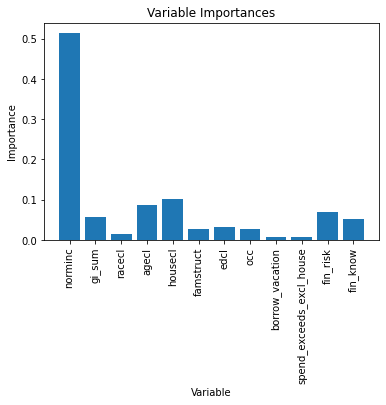

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from category_encoders import LeaveOneOutEncoder, TargetEncoder, OneHotEncoder, OrdinalEncoder, BinaryEncoder

def rf_regression(encoder=OneHotEncoder, dep_col = 'asset', df=df, x_cols=None):
    
    import warnings
    warnings.filterwarnings("ignore", message="is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead")
    
    df = df.copy()
    
    df['const'] = 1
    
    if x_cols is None:
        x_cols = [c for c in df.columns if c != dep_col]
    
    y = df[dep_col]

    enc = encoder()
    X = enc.fit_transform(df[x_cols], y)

    train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size = 0.3)

    rf = RandomForestRegressor()
    rf.fit(train_features, train_labels)

    # Set the style
    import matplotlib.pyplot as plt

    feature_list = list(X.columns)
    importances = list(rf.feature_importances_)# List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

    x_values = list(range(len(importances)))# Make a bar chart
    plt.bar(x_values, importances, orientation = 'vertical')# Tick labels for x axis
    plt.xticks(x_values, feature_list, rotation='vertical')# Axis labels and title
    plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

    return rf.score(test_features, test_labels), feature_importances, X, y

x_cols = 'norminc racecl agecl housecl famstruct edcl occ borrow_vacation spend_exceeds_excl_house'.split()
x_cols = [
    'norminc',
    'housecl',
    'racecl',
    'famstruct',
    'occ',
    'borrow_vacation',
    'spend_exceeds_excl_house',
    'age_1',
    'age_2',
    'ed_1',
    'ed_2',
    'fin_risk',
    'shop_credit_2',
    'fin_know',
    'gi_sum',
    'indcat',
    'debt2inc']

x_cols = [
 'norminc',
 'homeeq', 
 'debt2inc',
 'debt',
 'age_1',
 'age_2',
 'agecl',
 'fin_know',
 'gi_sum',
 'occ',
 'shop_credit', 'shop_credit_2', 
 'fin_risk',
 'edcl',
 'racecl']

x_cols = ['norminc', 'gi_sum', 'racecl', 'agecl', 'housecl', 'famstruct', 
          'edcl', 'occ', 'borrow_vacation', 'spend_exceeds_excl_house', 'fin_risk', 'fin_know']

score, fi, X, y = rf_regression(x_cols=x_cols, df=regr, encoder=TargetEncoder)
score

In [16]:
fi

[('norminc', 0.51),
 ('gi_sum', 0.06),
 ('racecl', 0.02),
 ('agecl', 0.09),
 ('housecl', 0.1),
 ('famstruct', 0.03),
 ('edcl', 0.03),
 ('occ', 0.03),
 ('borrow_vacation', 0.01),
 ('spend_exceeds_excl_house', 0.01),
 ('fin_risk', 0.07),
 ('fin_know', 0.05)]

In [17]:
#X_ = sm.add_constant(X)

display(X_.head())
m = OLS(y, X_).fit()
m.summary()

,const,norminc_ihs,gi_sum_ihs,racecl_1,racecl_2,agecl_35-44,agecl_45-54,agecl_55-64,agecl_65-74,agecl_<35,...,fin_know_1,fin_know_2,fin_know_3,fin_know_4,fin_know_5,fin_know_6,fin_know_7,fin_know_8,fin_know_9,fin_know_10
2456,1.0,10.011355,9.798127,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
15988,1.0,10.832336,0.000000,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
27391,1.0,13.248249,0.000000,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
20418,1.0,11.890126,0.000000,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
22472,1.0,12.433741,12.122691,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  asset   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     3390.
Date:                Tue, 20 Oct 2020   Prob (F-statistic):               0.00
Time:                        21:28:56   Log-Likelihood:            -2.6964e+06
No. Observations:              189896   AIC:                         5.393e+06
Df Residuals:                  189849   BIC:                         5.393e+06
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                      -5.093e+05   3902.856   -130.506      0.000   -5.17e+05   -5.02e+05
norminc_ihs                 1.926e+05   1222.971    157.484      0.000     1.9e+05    1.95e+05
gi_sum_ihs                  7878.9666    190.071     41.453      0.000    7506.432    8251.502
racecl_1                   -2.388e+05   2205.246   -108.269      0.000   -2.43e+05   -2.34e+05
racecl_2                   -2.706e+05   2105.868   -128.491      0.000   -2.75e+05   -2.66e+05
agecl_35-44                -1.837e+05   2201.647    -83.458      0.000   -1.88e+05   -1.79e+05
agecl_45-54                -1.085e+05   2121.900    -51.140      0.000   -1.13e+05   -1.04e+05
agecl_55-64                -7441.9525   1976.744     -3.765      0.000   -1.13e+04   -3567.581
agecl_65-74                -3.086e+04   2426.872    -12.717      0.000   -3.56e+04   -2.61e+04
agecl_<35                  -2.157e+05   2077.018   -103.832      0.000    -2.2e+05   -2.12e+05
agecl_>=75                  3.688e+04   2828.573     13.039      0.000    3.13e+04    4.24e+04
housecl_1                  -1.548e+05   2350.995    -65.864      0.000   -1.59e+05    -1.5e+05
housecl_2                  -3.545e+05   2025.217   -175.043      0.000   -3.58e+05   -3.51e+05
famstruct_1                -9.924e+04   2163.389    -45.871      0.000   -1.03e+05    -9.5e+04
famstruct_2                -8.414e+04   2199.939    -38.248      0.000   -8.85e+04   -7.98e+04
famstruct_3                -1.504e+05   2297.186    -65.481      0.000   -1.55e+05   -1.46e+05
famstruct_4                -6.876e+04   2038.121    -33.739      0.000   -7.28e+04   -6.48e+04
famstruct_5                -1.068e+05   1973.975    -54.092      0.000   -1.11e+05   -1.03e+05
edcl_College               -1.396e+04   2085.566     -6.695      0.000   -1.81e+04   -9875.440
edcl_HS/GED                -1.802e+05   1682.637   -107.081      0.000   -1.83e+05   -1.77e+05
edcl_No HS                 -1.713e+05   2054.813    -83.361      0.000   -1.75e+05   -1.67e+05
edcl_Some College          -1.439e+05   1767.331    -81.429      0.000   -1.47e+05    -1.4e+05
occ_1                      -5.462e+04   2388.573    -22.865      0.000   -5.93e+04   -4.99e+04
occ_2                      -1.281e+05   2572.231    -49.795      0.000   -1.33e+05   -1.23e+05
occ_3                      -8.271e+04   2899.915    -28.523      0.000   -8.84e+04    -7.7e+04
occ_4                      -1.196e+05   3488.295    -34.298      0.000   -1.26e+05   -1.13e+05
occ_5                      -1.378e+05   3792.780    -36.324      0.000   -1.45e+05    -1.3e+05
occ_6                       4.078e+04   8815.882      4.626      0.000    2.35e+04    5.81e+04
occ_7                       -2.73e+04   2436.217    -11.207      0.000   -3.21e+04   -2.25e+04
borrow_vacation_1          -2.541e+05   248

# Blinder-Oaxaca Decomposition

In [18]:
import statsmodels.api as sm
from statsmodels.stats.oaxaca import OaxacaBlinder

model = OaxacaBlinder(y, X, 'racecl', hasconst = True)
model.two_fold().summary()

Oaxaca-Blinder Two-fold Effects

Unexplained Effect: 48858.74718
Explained Effect: 155697.90924
Gap: 204487.93239


# Other Relationships

In [19]:
dfs[['asset','debt','networth']].corr()

,asset,debt,networth
asset,1.000000,0.227578,0.999395
debt,0.227578,1.000000,0.193570
networth,0.999395,0.193570,1.000000


In [20]:
dfs['homeeq_gtz'] = dfs.homeeq > 0
df['homeeq_gtz'] = df.homeeq > 0
dfs.groupby(['race']).homeeq_gtz.mean()

race
black    0.419768
hisp     0.430111
other    0.546483
white    0.705256
Name: homeeq_gtz, dtype: float64

In [21]:
dfs[dfs.homeeq_gtz].groupby(['race']).homeeq.mean()

race
black    106164.688999
hisp     138047.576320
other    318672.335865
white    218868.847222
Name: homeeq, dtype: float64

In [22]:
df[df.homeeq_gtz].groupby(['famstruct']).case_id.count()

famstruct
1    1421
2    1096
3    3005
4    6885
5    8050
Name: case_id, dtype: int64

In [23]:
dfs.groupby(['race', dfs.networth > 0]).lt_planner.mean().unstack()

networth,False,True
race,,
black,0.473328,0.576024
hisp,0.352575,0.510721
other,0.565004,0.713131
white,0.488531,0.696274


In [24]:
# Races dont differ in debts
dfs.groupby(['race', dfs.gi_sum > 0]).debt.mean().unstack()

gi_sum,False,True
race,,
black,57555.774571,50835.100746
hisp,62950.787501,65478.546366
other,146506.690949,102650.221833
white,108023.757753,106651.656140


In [25]:
# Races dont differ in debts
dfs.groupby(['race', dfs.gi_sum > 0]).debt.mean().unstack()

gi_sum,False,True
race,,
black,57555.774571,50835.100746
hisp,62950.787501,65478.546366
other,146506.690949,102650.221833
white,108023.757753,106651.656140


In [26]:
dfs.groupby(['nincpctlecat']).saved.mean()

nincpctlecat
1     0.340749
2     0.343864
3     0.431714
4     0.493554
5     0.551771
6     0.563987
7     0.641861
8     0.654737
9     0.730846
10    0.774550
11    0.800640
12    0.922368
Name: saved, dtype: float64

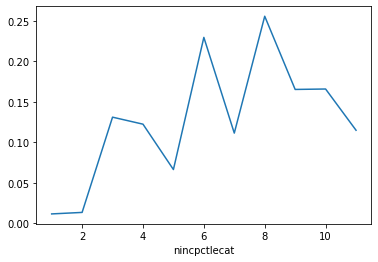

In [27]:
# Saving distinguishes people with positive networths from negative networths most 
# in the middle incomes, and is not as predictive for the poorest and richest. 
t = dfs.groupby(['nincpctlecat', dfs.networth > 0]).saved.mean().unstack()
t = t[True] - t[False]
t.plot()


In [28]:
dfs.debt2inc.describe()

count    200000.000000
mean          1.246104
std           3.126303
min           0.000000
25%           0.010263
50%           0.501457
75%           1.650036
max         149.326097
Name: debt2inc, dtype: float64

In [29]:
# Transfers have maybe 10% effect on debt
dfs.groupby([dfs.gi_sum > 0]).debt.mean()

gi_sum
False     94829.807123
True     101495.252418
Name: debt, dtype: float64

In [30]:
# Families that have recieved transfers have assets twice as large
t = dfs[dfs.age_1 < 45].copy()
t = t.groupby(['race',t.gi_sum > 0]).asset.median().unstack()
t['diff'] = t[True] - t[False]
t

TypeError: Unordered Categoricals can only compare equality or not

In [ ]:
# But the also have larger incomes
t = dfs[dfs.age_1 < 45].copy()
t = t.groupby(['race',t.gi_sum > 0]).norminc.median().unstack()
t['diff'] = t[True] - t[False]
t

In [ ]:
# Whites and blacks hold similar amounts of debt, and debt to income, 
# across income ranges. 
dfs.groupby(['nincpctlecat', 'race']).mean()[['debt','debt2inc']].unstack()

In [ ]:
t = dfs[
    (dfs.age_1 < 50) & (dfs.age_1 > 40 ) & (dfs.homeeq > 0) 
]

t = t.groupby(['race','nincpctlecat']).asset.mean().unstack().T
t.columns = list(t.columns)
t['r'] = t.black / t.white

t